Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV] END max_depth=20, min_samples_leaf=1000, min_samples_split=10000, n_estimators=50; total time= 8.5min
[CV] END max_depth=10, min_samples_leaf=200, min_samples_split=1000, n_estimators=100; total time= 9.9min
[CV] END max_depth=10, min_samples_leaf=500, min_samples_split=10000, n_estimators=50; total time= 4.3min
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10, n_estimators=50; total time= 9.9min
[CV] END max_depth=20, min_samples_leaf=500, min_samples_split=10, n_estimators=100; total time=20.1min
[CV] END max_depth=100, min_samples_leaf=10, min_samples_split=1000, n_estimators=50; total time=12.7min
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=100, n_estimators=50; total time= 6.9min
[CV] END max_depth=50, min_samples_leaf=5, min_samples_split=10000, n_estimators=100; total time=17.9min
[CV] END max_depth=50, min_samples_leaf=100, min_samples_split=10, n_estimators=50; total time=11.2min


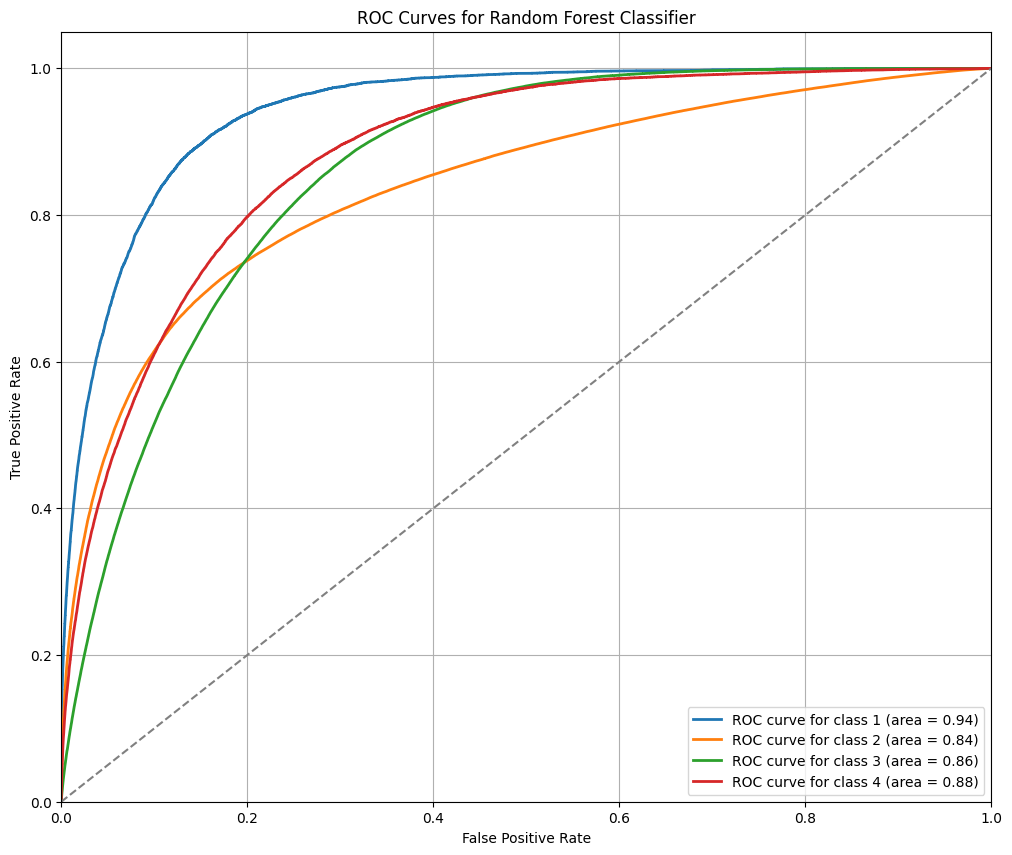

Random Forest Accuracy: 0.7286

Classification Report:
              precision    recall  f1-score   support

           1       0.15      0.52      0.23      9362
           2       0.93      0.73      0.82    873568
           3       0.44      0.76      0.56    188164
           4       0.21      0.41      0.27     27219

    accuracy                           0.73   1098313
   macro avg       0.43      0.61      0.47   1098313
weighted avg       0.83      0.73      0.76   1098313



C:\Users\amrut\AppData\Local\Temp\ipykernel_28656\1298322522.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')


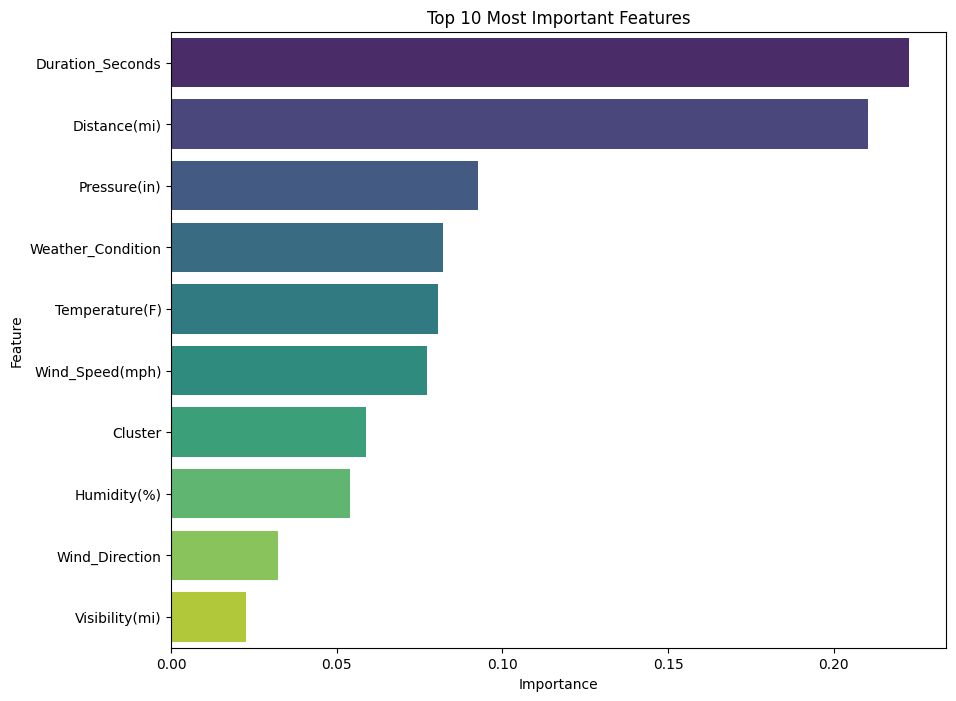

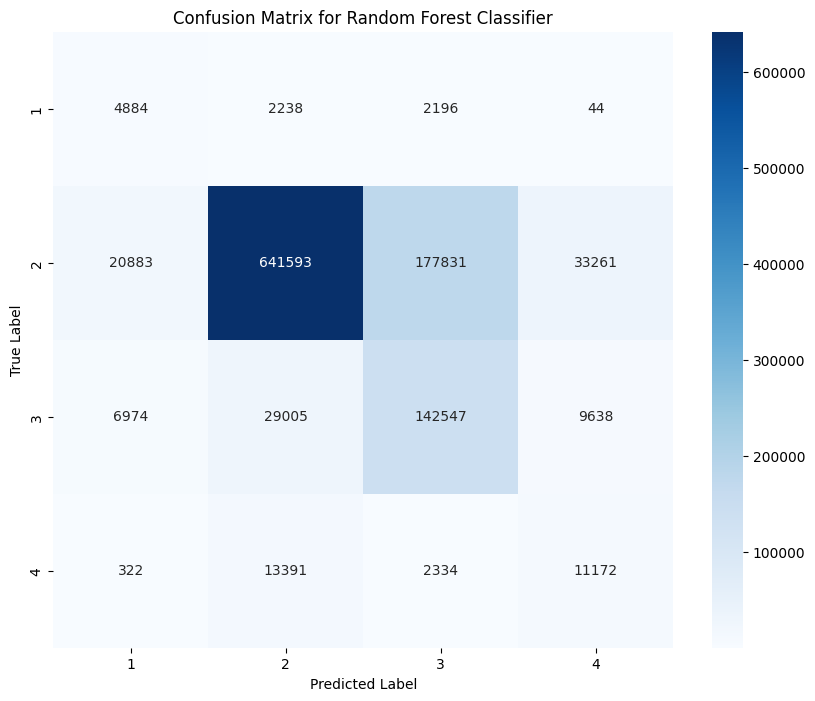

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns


train_data = pd.read_csv("Train_Set.csv")
val_data = pd.read_csv("Validation_Set.csv")
test_data = pd.read_csv('Test_Set.csv')

X_train = train_data.drop(columns=["Severity"])
y_train = train_data["Severity"]

X_test = test_data.drop(columns=["Severity"])
y_test = test_data["Severity"]

combined_data = pd.concat([train_data, val_data], axis=0)
X_combined = combined_data.drop(columns=["Severity"])
y_combined = combined_data["Severity"]

# Create an indicator array for the validation set split
split_index = [-1] * len(train_data) + [0] * len(val_data)
predefined_split = PredefinedSplit(test_fold=split_index)

rf_params = {
    'min_samples_split': [10, 100, 500, 1000, 10000],
    'min_samples_leaf': [5, 10, 100, 200, 500, 1000, 10000],
    'n_estimators': [50, 100],
    'max_depth': [10, 20, 50, 100] 
}

model_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    cv=predefined_split,
    param_distributions=rf_params,
    n_jobs=1,
    n_iter=20,
    scoring= 'neg_mean_squared_error',
    verbose=2,
    error_score='raise'
)

model_rf.fit(X_combined, y_combined)

best_rf_model = model_rf.best_estimator_
print("Best parameters for Random Forest: ", model_rf.best_params_)

y_pred = best_rf_model.predict(X_test)

# Binarize the true labels for ROC curve (if multi-class)
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

# Get probabilities for the ROC curve (required for AUC calculation)
y_prob = best_rf_model.predict_proba(X_test)

# Plot ROC curves for each class
plt.figure(figsize=(12, 10))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest Classifier')
plt.legend(loc="lower right")
plt.grid()
plt.show()


accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to see feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_10_features = importance_df.head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.show()

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()